###### Content under Creative Commons Attribution license CC-BY 4.0, [Lattice-Boltzmann code](https://github.com/pmocz/latticeboltzmann-python) by [Philip Mocz](https://pmocz.github.io/) under GNU General Public License v3.0 (c) 2020 Daniel Koehn.

In [1]:
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, 'r').read())

# 2D Navier-Stokes: Fluid flow past obstacles

<img src="images/Karmansche_Wirbelstr_kleine_Re.JPG" width="95%">

In the last lecture, we solved the [Cavity Flow](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/09_Navier_Stokes_2D/01_2D_Navier-Stokes_Cavity_Flow.ipynb) and [Channel Flow](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/09_Navier_Stokes_2D/02_2D_Navier-Stokes_Channel_Flow.ipynb) problems using the 2D Navier-Stokes equations. The low Reynolds numbers resulted in a quite boring laminar flow field, due to the dominance of viscous forces, mitigating the occurence of vortices. 

Today, we want to study a more interesting flow pattern past a cylindrical obstacle at higher Reynolds numbers. For an easier implementation of the boundary conditions at the obstacle location within the fluid and dealing with the dominant non-linear advection term in the Navier-Stokes equations, we will describe fluid motion in a different way by using the Boltzmann equation instead of the Navier-Stokes equations. This problem can be easily numerically solved using the Lattice-Boltzmann method.

## Navier-Stokes vs. Boltzmann equation

So far, we used the following governing equations for fluid flow in an incompressible medium, consisting of the **conservation of mass (continuity)** equation

$$\vec{\nabla} \cdot  \vec{v} = 0$$

and the **conservation of momentum equation** in vector form for a velocity field $\vec{v}$

$$\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v}=-\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v}$$

This represents three scalar equations, one for each velocity component $(u,v,w)$. But we will solve it only in two dimensions, so there will be two scalar equations.

As described earlier in the lecture, these equations are based on the continuum assumption. However, we can also approximate the Navier-Stokes equations by an approach from statistical physics. Classical mechanics deals with the physics of individual point masses, while continuum mechanics averages over all particles in a medium. Statistical mechanics bridges the gap between both physical views of the universe, by studying the mechanics of particle distributions. 

In statstical mechanics, we describe the position and velocities of a large number of particles by a phase space density distribution $f$. Within this framework, fluid flow can be modelled using the **Boltzmann equation**:

$$\frac{\partial f}{\partial t}+(\vec{c}\cdot\nabla) f= \frac{f_{eq}-f}{\tau}$$

Does this look familiar? The term on the LHS 

$$\frac{\partial f}{\partial t}+(\vec{c}\cdot\nabla) f$$

obviously describes **advective transport of f** with velocity $c$. What could the term on the RHS represent? When comparing the Boltzmann with the Navier-Stokes equations, you might come to the conclusion that this could describe transport of **f by diffusion or atomic collisions**. Compared to Navier-Stokes equations, the collision term in the Boltzmann equation describes the difference between the current phase space density distribution $f$ and an equilibrium distribution $f_{eq}$ related to a steady state of the flow problem. As long as $f$ deviates from $f_{eq}$ we have unsteady fluid flow. 

The characteristic timescale $\tau$ describes the average collision time between particles. $\tau$ can be linked to a macroscopic property of the medium we already know: the dynamic viscosity. This is an interesting physical interpretation of viscosity. If $\tau$ is large, the probability of atomic interaction is quite small, leading to large viscosities. On the other hand, if $\tau$ is small, we get significant atomic interaction, resulting in small viscosities. 

It can be shown that by averaging the phase space density distribution $f$, we get macroscopic density $\rho$ and velocity fields $\vec{u} = (u_x, u_y)^T$ and subsequently the Navier-Stokes equations.  For further details, I refer to [Wagner (2008)](https://www.ndsu.edu/fileadmin/physics.ndsu.edu/Wagner/LBbook.pdf)

## Lattice-Boltzmann Method

To solve the Boltzmann equation, we can use the [Lattice-Boltzmann method](https://de.wikipedia.org/wiki/Lattice-Boltzmann-Methode). Similar to the combination of the Marker-in-Cell and FTCS FD method to solve the [2D advection-diffusion problem](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/08_Convection_2D/03_2D_Linear_Advection_Diffusion.ipynb), the Lattice-Boltzmann method first solves the advection problem, followed by the collision problem. 

A detailed description on how to use the Lattice-Boltzmann method to solve fluid flow can be found in this excellent piece [Create Your Own Lattice Boltzmann Simulation (With Python)](https://medium.com/swlh/create-your-own-lattice-boltzmann-simulation-with-python-8759e8b53b1c) by the computational astrophysicist [Philip Mocz](https://pmocz.github.io/) from Princeton university. We will also use his very short and compact [Python-code](https://github.com/pmocz/latticeboltzmann-python) with some minor modifications. 

Let 's get started ...

In [2]:
# Import Python libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

As usual, we first define the modelling parameters ...

In [3]:
# Simulation parameters
Nx                  = 600    # resolution x-dir
Ny                  = 100    # resolution y-dir
rho0                = 100    # average density
tau                 = 0.6      # collision timescale
#tau                  = 1.      # collision timescale
Nt                   = 4000   # number of timesteps
plotRealTime = True     # switch on for plotting as the simulation goes along

# Lattice speeds / weights
NL = 9
idxs = np.arange(NL)
cxs = np.array([0, 0, 1, 1, 1, 0,-1,-1,-1])
cys = np.array([0, 1, 1, 0,-1,-1,-1, 0, 1])
weights = np.array([4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36]) # sums to 1

... and initial conditions.

In [4]:
# Initial Conditions
F = np.ones((Ny,Nx,NL)) #* rho0 / NL
np.random.seed(42)
F += 0.01*np.random.randn(Ny,Nx,NL)
X, Y = np.meshgrid(range(Nx), range(Ny))
F[:,:,3] += 2 * (1+0.2*np.cos(2*np.pi*X/Nx*4))
rho = np.sum(F,2)
for i in idxs:
    F[:,:,i] *= rho0 / rho

Let 's take a look at the initial phase space distribution $F$ ...

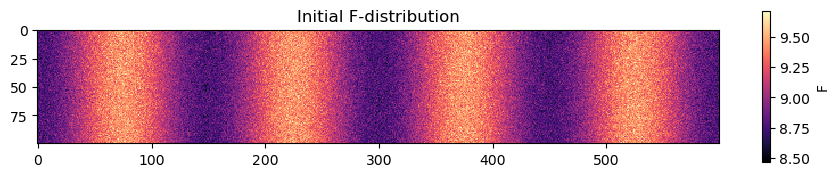

In [5]:
fig = plt.figure(figsize=(11,2), dpi=100)
cmap = 'magma'

im = plt.imshow(F[:,:,0], interpolation='none', cmap=cmap)
plt.title('Initial F-distribution')
cbar = plt.colorbar(im)
cbar.set_label('F')

... and the resulting initial flow field

Text(0.5, 1.0, 'Initial flow field')

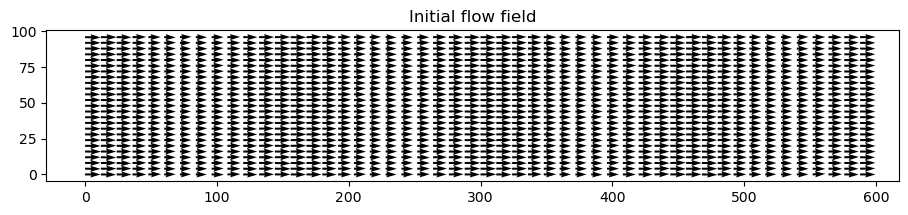

In [6]:
fig = plt.figure(figsize=(11,2), dpi=100)

# compute density and velocity field from F
rhoi = np.sum(F,2)
uxi  = np.sum(F*cxs,2) / rhoi
uyi = np.sum(F*cys,2) / rhoi

# spatial sample interval for plotting vector arrows
dxs = 12
dys = 4

# plot flow field field
im = plt.quiver(X[::dys,::dxs],Y[::dys,::dxs],uxi[::dys,::dxs],uyi[::dys,::dxs])
plt.title('Initial flow field')

Next, we define the boundaries of the obstacle using a mask. You can later edit this part, to replace the cylinder by other objects.

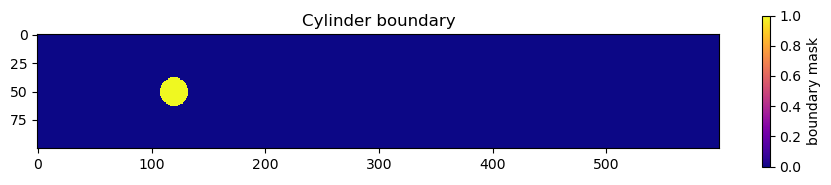

In [7]:
# Define Cylinder boundary mask
X, Y = np.meshgrid(range(Nx), range(Ny))
cylinder = (X - Nx/5)**2 + (Y - Ny/2)**2 < (Ny/8)**2

fig = plt.figure(figsize=(11,2), dpi=100)
cmap = 'plasma'

im = plt.imshow(cylinder, interpolation='none', cmap=cmap)
plt.title('Cylinder boundary')
cbar = plt.colorbar(im)
cbar.set_label('boundary mask')

Finally, we assemble and run the Lattice-Boltzmann code to model the fluid flow past the cylinder

<IPython.core.display.Javascript object>


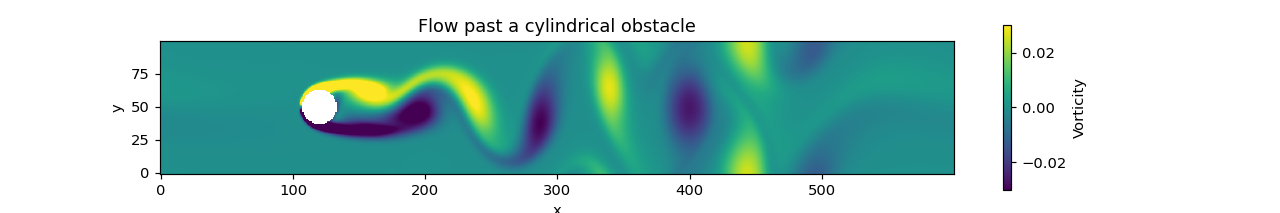

In [8]:
%matplotlib notebook

# Calculate fluid variables
ux  = np.sum(F*cxs,2) / rho
uy  = np.sum(F*cys,2) / rho

# Compute vorticity
ux[cylinder] = 0
uy[cylinder] = 0
vorticity = (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - (np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1))
vorticity[cylinder] = np.nan

# Plot initial vorticity field
fig = plt.figure(figsize=(12, 2),dpi=80)
plt.tight_layout()
im = plt.imshow(vorticity, cmap='viridis')
plt.title('Flow past a cylindrical obstacle')
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar(im)
cbar.set_label('Vorticity')
plt.clim(-.03, .03)
ax = plt.gca()
ax.invert_yaxis()
ax.set_aspect('equal')
    
# activate interactive plot
plt.ion()    
plt.show(block=False)

# Simulation Main Loop
for it in range(Nt):

    # Drift
    for i, cx, cy in zip(idxs, cxs, cys):
        F[:,:,i] = np.roll(F[:,:,i], cx, axis=1)
        F[:,:,i] = np.roll(F[:,:,i], cy, axis=0)

    # Set reflective boundaries
    bndryF = F[cylinder,:]
    bndryF = bndryF[:,[0,5,6,7,8,1,2,3,4]]

    # Calculate fluid variables
    rho = np.sum(F,2)
    ux  = np.sum(F*cxs,2) / rho
    uy  = np.sum(F*cys,2) / rho

    # Apply Collision
    Feq = np.zeros(F.shape)
    for i, cx, cy, w in zip(idxs, cxs, cys, weights):
        
        Feq[:,:,i] = rho * w * ( 1 + 3*(cx*ux+cy*uy)  + 9*(cx*ux+cy*uy)**2/2 - 3*(ux**2+uy**2)/2 )
        
    F += -(1.0/tau) * (F - Feq)
        
    # Apply boundary 
    F[cylinder,:] = bndryF
        
    # plot in real time - color 1/2 particles blue, other half red
    if (plotRealTime and (it % 10) == 0) or (it == Nt-1):
        
        # Compute vorticity and update imshow plot
        ux[cylinder] = 0
        uy[cylinder] = 0
        vorticity = (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - (np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1))
        vorticity[cylinder] = np.nan
        im.set_data(vorticity)
        fig.canvas.draw()

# Save figure
plt.savefig('latticeboltzmann.png',dpi=240)
plt.show()

Wow, this is a very cool modelling result, which looks very much like the von-Karman vortex street in the laboratory experiment, shown at the beginning of this notebook. As I said before, physicist can predict the future ...

As mentioned earlier, the characteristic time scale $\tau$ is related to the dynamic viscosity $\nu$ of the fluid via

$$\nu = \rho (\tau-\frac{1}{2}) \Delta t$$

with the density $\rho$ and time step $\Delta t$. By increasing $\tau$ you should increase the dynamic viscocity and therefore decrease the Reynolds number, which should lead to a more laminar flow pattern. Try it by yourself. 

Below, I linked a short video showing the effect of different Reynolds numbers on the fluid flow past a cylinder. At low Reynolds numbers you get laminar flow, while higher Reynolds numbers lead to turbulent flow and the development of a von-Karmann vortex street.

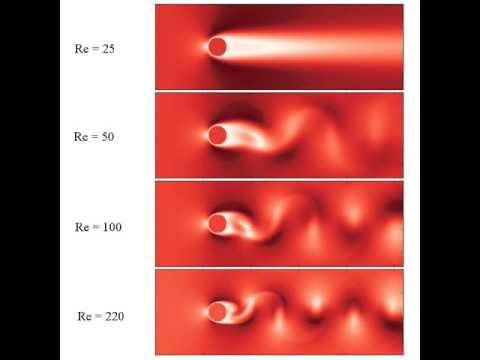

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('8WtEuw0GLg0') 

## What we learned:

- Statistical physics provides a different interpretation of fluid flow and connects the statistical motion of point mass distributions with macroscopic fields in continuum mechnanics

- The Boltzmann equation can be very effectivley solved using the Lattice-Boltzmann method. It also delivers an easy approach to incorporate obstacles in a fluid flow field. 

- The complexity of fluid flow patterns past an obstacle depends on the Reynolds number. Low Reynolds numbers lead to laminar flow, while large Reynolds numbers introduce a turbulent flow field, dominated by alternating vortices.